In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.methods import data_formatting, dict_mapping
from utils.setup import df_config
from utils.map import df_map_features

# Load dataset from .dat
df = pd.read_csv("../data/imports-85.data", names=df_config["head"])

# Format the dataset: Splitting into completely existend dataframe
# (used for modeling) and dataframe with missing values (used for evaluation)
train_vals, eval_vals, target_vals, target_eval_vals = data_formatting(
    df, "fuel-type")


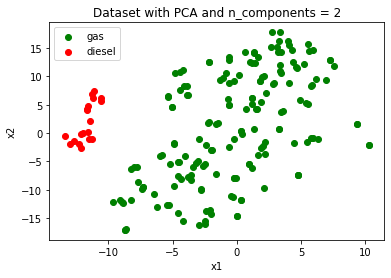

In [2]:
from utils.plotting import plot_dataset_pcatsne
from utils.pcatsne import standardized_tsne

# Experimenting with n_components to get a good variance ratio
n_components = 2
ramdom_state = 8

tsne, x_tsne = standardized_tsne(train_vals, n_components, ramdom_state)
xtsne, xs_tsne = standardized_tsne(eval_vals, n_components, ramdom_state)

plot_dataset_pcatsne(x_tsne, target_vals, "Dataset with PCA and n_components = %i" %
                     n_components, ["diesel", "gas"])

In [3]:
# Split dataset in trianset and testset
from sklearn.model_selection import train_test_split

# Split train/test of main dataset (train_vals)
x_train, x_test, y_train, y_test = train_test_split(
    x_tsne, target_vals, test_size=0.35, random_state=15)


In [4]:
from utils.plotting import plot_knn_boundaries
from sklearn.neighbors import KNeighborsClassifier

_n_neighbors = 1

for weights in ['uniform', 'distance']:
  neigh = KNeighborsClassifier(n_neighbors=_n_neighbors, weights=weights)
  neigh.fit(x_train, y_train)

  # Get predicted result and storing it in a dataframe
  result = neigh.predict(xs_tsne)
  result = pd.DataFrame(
      {'predicted fuel-type': result, 'actual fuel-type': target_eval_vals})
  # Replace the logical values with their corresponding fuel-types
  result = result.replace(df_map_features["fuel-type-back"][0])

  print(f"Result for {weights}-classifier:\n{result}\n")


Result for uniform-classifier:
   predicted fuel-type actual fuel-type
0                  gas              gas
1                  gas              gas
2                  gas              gas
3                  gas              gas
4                  gas              gas
5                  gas              gas
6                  gas              gas
7                  gas              gas
8               diesel           diesel
9                  gas              gas
10                 gas              gas
11                 gas              gas

Result for distance-classifier:
   predicted fuel-type actual fuel-type
0                  gas              gas
1                  gas              gas
2                  gas              gas
3                  gas              gas
4                  gas              gas
5                  gas              gas
6                  gas              gas
7                  gas              gas
8               diesel           diesel
9               

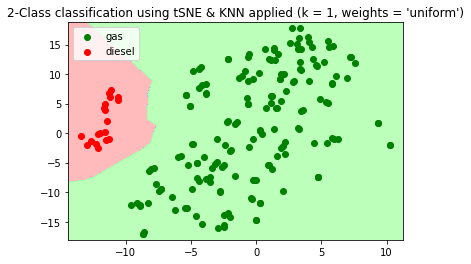

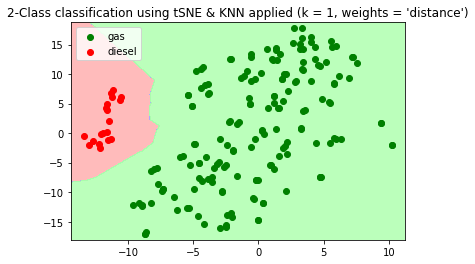

In [5]:
for weights in ['uniform', 'distance']:
  neigh = KNeighborsClassifier(n_neighbors=_n_neighbors, weights=weights)
  neigh.fit(x_train, y_train)

  plot_knn_boundaries(x_tsne, target_vals, neigh, "2-Class classification using tSNE & KNN applied (k = %i, weights = '%s')"
                      % (_n_neighbors, weights), ["diesel", "gas"])


# Performing Clustering & KMeans if classes where hidden

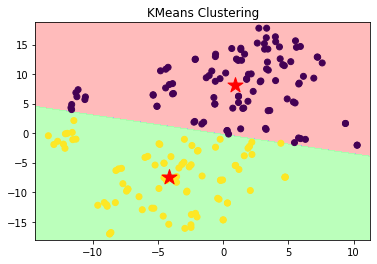

Score: -9150.642738008808


In [6]:
from utils.plotting import plot_kmeans_boundaries
from sklearn.cluster import KMeans

# Cast to double
x_tsne = x_tsne.astype('double')

kmeans = KMeans(n_clusters=2, max_iter=3_000)
kmeans.fit(x_tsne)
y_pred = kmeans.predict(x_tsne)

plot_kmeans_boundaries(
    x_tsne, x_tsne[1], y_pred, kmeans.cluster_centers_, kmeans, 'KMeans Clustering')

score = kmeans.score(x_tsne, target_vals)
print(f"Score: {score}")


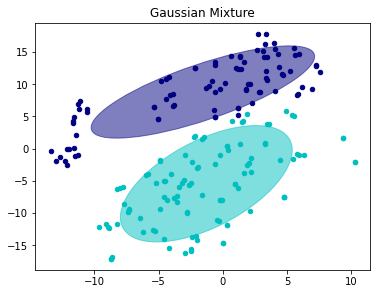

In [7]:
from utils.plotting import plot_gaussian_cluster
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(
    n_components=2,
    covariance_type='full').fit(x_tsne)

y_pred = gmm.predict(x_tsne)

plot_gaussian_cluster(x_tsne, y_pred, gmm.means_, gmm.covariances_, 0,
                      'Gaussian Mixture')
